# Consumer Complaints NLP models

There are two models created to predict product based on consumer complaints: LSMT model and Attention model

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Input, GlobalAveragePooling1D, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from keras import backend as K
from keras.engine.topology import Layer

Using TensorFlow backend.


In [3]:
df = pd.read_csv('consumer_complaints.csv')

In [4]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760


## Data cleansing and normalization

In [5]:
df = df[~df['Consumer complaint narrative'].isna()]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199970 entries, 1 to 903982
Data columns (total 18 columns):
Date received                   199970 non-null object
Product                         199970 non-null object
Sub-product                     147788 non-null object
Issue                           199970 non-null object
Sub-issue                       113532 non-null object
Consumer complaint narrative    199970 non-null object
Company public response         95433 non-null object
Company                         199970 non-null object
State                           199407 non-null object
ZIP code                        199389 non-null object
Tags                            33446 non-null object
Consumer consent provided?      199970 non-null object
Submitted via                   199970 non-null object
Date sent to company            199970 non-null object
Company response to consumer    199970 non-null object
Timely response?                199970 non-null object
Consumer di

In [7]:
df.Product.value_counts()

Debt collection                                                                 47915
Mortgage                                                                        36582
Credit reporting                                                                31592
Credit card                                                                     18842
Bank account or service                                                         14888
Credit reporting, credit repair services, or other personal consumer reports    14671
Student loan                                                                    13304
Consumer Loan                                                                    9474
Credit card or prepaid card                                                      3355
Checking or savings account                                                      2142
Payday loan                                                                      1748
Money transfers                                       

In [8]:

df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

In [9]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


clean_text('''An ??? account on my && credit report has a mistaken date. I / / mailed in a debt validation letter to allow fix XXXX to correct the information. I received a letter in the mail, stating that Experian received my correspondence and found it to be " suspicious '' and that " I did n't write it ''. Experian 's letter is worded to imply that I am incapable of writing my own letter. I was deeply offended by this implication. 
I called Experian to figure out why my letter was so suspicious. I spoke to a representative who was incredibly unhelpful, She did not effectively answer any questions I asked of her, and she kept ignoring what I was saying regarding the offensive letter and my dispute process. I feel the representative did what she wanted to do, and I am not satisfied. It is STILL not clear to me why I received this letter. I typed this letter, I signed this letter, and I paid to mail this letter, yet Experian willfully disregarded my lawful request. 
I am disgusted with this entire situation, and I would like for my dispute to be handled appropriately, and I would like for an Experian representative to contact me and give me a real explanation for this letter.''')

'account credit report mistaken date mailed debt validation letter allow fi correct information received letter mail stating eperian received correspondence found suspicious nt write eperian letter worded imply incapable writing letter deeply offended implication called eperian figure letter suspicious spoke representative incredibly unhelpful effectively answer questions asked kept ignoring saying regarding offensive letter dispute process feel representative wanted satisfied still clear received letter typed letter signed letter paid mail letter yet eperian willfully disregarded lawful request disgusted entire situation would like dispute handled appropriately would like eperian representative contact give real eplanation letter'

In [10]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)

df["Consumer complaint narrative"]

0         outdated information credit report previously ...
1         purchased new car car dealer called citizens b...
2         account credit report mistaken date mailed deb...
3         company refuses provide verification validatio...
4         complaint regards square two financial refer c...
                                ...                        
199673    son taken 2012 er visit insurance time hospita...
199674    13 without authorization bank america withdrew...
199675    account previously disputed sold towers area e...
199676    contacted email caliber home loans refinance c...
199677    debit included chapter bk almost two years let...
Name: Consumer complaint narrative, Length: 199678, dtype: object

In [11]:
print_plot(10)

NameError: name 'print_plot' is not defined

In [12]:
print_plot(100)

NameError: name 'print_plot' is not defined

(array([1.88782e+05, 1.05830e+04, 2.17000e+02, 5.80000e+01, 2.20000e+01,
        4.00000e+00, 4.00000e+00, 5.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([   0. ,  251.6,  503.2,  754.8, 1006.4, 1258. , 1509.6, 1761.2,
        2012.8, 2264.4, 2516. ]),
 <a list of 10 Patch objects>)

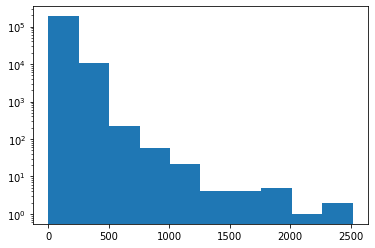

In [13]:
# Cut off text length is around 250
messagelength = df['Consumer complaint narrative'].apply(lambda x: len(x.split()))
plt.hist(messagelength, log = True)

In [14]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 10

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 108069 unique tokens.


In [15]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

print(X[0])

Shape of data tensor: (199678, 250)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 

In [16]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (199678, 13)


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(179710, 250) (179710, 13)
(19968, 250) (19968, 13)


## LSTM Modeling

In [18]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
model.add(LSTM(20, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 10)           500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                2480      
_________________________________________________________________
dense_1 (Dense)              (None, 13)                273       
Total params: 502,753
Trainable params: 502,753
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 161739 samples, validate on 17971 samples
Epoch 1/5
161739/161739 [==============================] - 1144s 7ms/step - loss: 1.3955 - acc: 0.5349 - val_loss: 1.0465 - val_acc: 0.6616
Epoch 2/5
161739/161739 [==============================] - 852s 5ms/step - loss: 1.0341 - acc: 0.6715 - val_loss: 0.8516 - val_acc: 0.7532
Epoch 3/5
161739/161739 [==============================] - 882s 5ms/step - loss: 0.8856 - acc: 0.7378 - val_loss: 0.7598 - val_acc: 0.7816
Epoch 4/5
161739/161739 [==============================] - 846s 5ms/step - loss: 0.7884 - acc: 0.7713 - val_loss: 0.7085 - val_acc: 0.7932
Epoch 5/5
161739/161739 [==============================] - 776s 5ms/step - loss: 0.7313 - acc: 0.7867 - val_loss: 0.6656 - val_acc: 0.8042


In [72]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

19968/19968 [==============================] - 24s 1ms/step
Test set
  Loss: 0.671
  Accuracy: 0.801


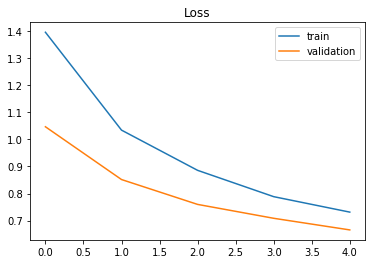

In [79]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show();

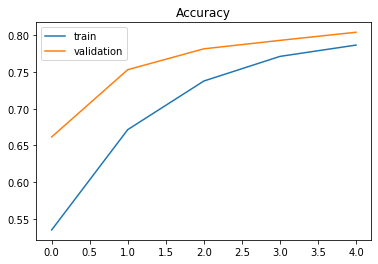

In [80]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.show();

Test with new complaint.

In [81]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[6.4740337e-02 4.5811664e-03 3.7975729e-02 6.5524626e-01 1.9073328e-01
  2.9743910e-02 7.5191469e-04 1.1461723e-03 5.7343715e-03 1.2943110e-03
  5.0070076e-03 4.4566256e-04 2.5998254e-03]] Credit card or prepaid card


Apply confusion matrix

In [19]:
y_train_predict = model.predict(X_train)

In [20]:
# confusion_matrix shows: label 1, 6, 7, 9, 10, and 12 have no prediction.  Because there are very little data for these labels.

y_train_predict_label = np.argmax(np.asarray(y_train_predict), axis = 1)
y_train_true_label = np.argmax(np.asarray(Y_train), axis =1)

print(y_train_predict_label)

print(y_train_true_label)

result_table = confusion_matrix(y_train_true_label, y_train_predict_label)

pd.DataFrame(data = result_table)

[ 7  4 10 ...  7  7  6]
[ 2  3  4 ... 11  0  4]


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,883,1402,845,592,1551,962,1163,1493,1206,399,778,62,2113
1,126,168,129,84,231,138,148,214,170,58,123,8,316
2,537,763,838,409,1210,625,786,888,879,152,451,53,942
3,1501,1890,1593,955,2752,1259,1918,2238,1874,404,1076,103,2456
4,2620,3028,3350,1899,8464,3628,3174,4361,4258,489,2244,187,3937
5,3073,3250,3666,2143,6378,3281,4147,5083,4794,634,2469,237,3908
6,52,43,45,34,89,49,43,65,63,14,41,8,87
7,97,140,99,66,159,80,136,146,126,39,78,4,183
8,2112,3519,2692,1643,3691,2317,2707,3631,3051,686,1814,217,4781
9,132,252,168,147,275,168,178,218,222,50,131,9,252



Position_Embedding and Attention is from https://github.com/foamliu/Self-Attention-Keras/blob/master/attention.py

In [21]:
class Position_Embedding(Layer):

    def __init__(self, size=None, mode='sum', **kwargs):
        self.size = size  
        self.mode = mode
        super(Position_Embedding, self).__init__(**kwargs)

    def call(self, x):
        if (self.size == None) or (self.mode == 'sum'):
            self.size = int(x.shape[-1])
        batch_size, seq_len = K.shape(x)[0], K.shape(x)[1]
        position_j = 1. / K.pow(10000., 2 * K.arange(self.size / 2, dtype='float32') / self.size)
        position_j = K.expand_dims(position_j, 0)
        position_i = K.cumsum(K.ones_like(x[:, :, 0]), 1) - 1 
        position_i = K.expand_dims(position_i, 2)
        position_ij = K.dot(position_i, position_j)
        position_ij = K.concatenate([K.cos(position_ij), K.sin(position_ij)], 2)
        if self.mode == 'sum':
            return position_ij + x
        elif self.mode == 'concat':
            return K.concatenate([position_ij, x], 2)

    def compute_output_shape(self, input_shape):
        if self.mode == 'sum':
            return input_shape
        elif self.mode == 'concat':
            return (input_shape[0], input_shape[1], input_shape[2] + self.size)



class Attention(Layer):

    def __init__(self, nb_head, size_per_head, **kwargs):
        self.nb_head = nb_head
        self.size_per_head = size_per_head
        self.output_dim = nb_head * size_per_head
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.WQ = self.add_weight(name='WQ',
                                  shape=(input_shape[0][-1], self.output_dim),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.WK = self.add_weight(name='WK',
                                  shape=(input_shape[1][-1], self.output_dim),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.WV = self.add_weight(name='WV',
                                  shape=(input_shape[2][-1], self.output_dim),
                                  initializer='glorot_uniform',
                                  trainable=True)
        super(Attention, self).build(input_shape)

    def Mask(self, inputs, seq_len, mode='mul'):
        if seq_len == None:
            return inputs
        else:
            mask = K.one_hot(seq_len[:, 0], K.shape(inputs)[1])
            mask = 1 - K.cumsum(mask, 1)
            for _ in range(len(inputs.shape) - 2):
                mask = K.expand_dims(mask, 2)
            if mode == 'mul':
                return inputs * mask
            if mode == 'add':
                return inputs - (1 - mask) * 1e12

    def call(self, x):
        if len(x) == 3:
            Q_seq, K_seq, V_seq = x
            Q_len, V_len = None, None
        elif len(x) == 5:
            Q_seq, K_seq, V_seq, Q_len, V_len = x
       
        Q_seq = K.dot(Q_seq, self.WQ)
        Q_seq = K.reshape(Q_seq, (-1, K.shape(Q_seq)[1], self.nb_head, self.size_per_head))
        Q_seq = K.permute_dimensions(Q_seq, (0, 2, 1, 3))
        K_seq = K.dot(K_seq, self.WK)
        K_seq = K.reshape(K_seq, (-1, K.shape(K_seq)[1], self.nb_head, self.size_per_head))
        K_seq = K.permute_dimensions(K_seq, (0, 2, 1, 3))
        V_seq = K.dot(V_seq, self.WV)
        V_seq = K.reshape(V_seq, (-1, K.shape(V_seq)[1], self.nb_head, self.size_per_head))
        V_seq = K.permute_dimensions(V_seq, (0, 2, 1, 3))
       
        A = K.batch_dot(Q_seq, K_seq, axes=[3, 3]) / self.size_per_head ** 0.5
        A = K.permute_dimensions(A, (0, 3, 2, 1))
        A = self.Mask(A, V_len, 'add')
        A = K.permute_dimensions(A, (0, 3, 2, 1))
        A = K.softmax(A)
       
        O_seq = K.batch_dot(A, V_seq, axes=[3, 2])
        O_seq = K.permute_dimensions(O_seq, (0, 2, 1, 3))
        O_seq = K.reshape(O_seq, (-1, K.shape(O_seq)[1], self.output_dim))
        O_seq = self.Mask(O_seq, Q_len, 'mul')
        return O_seq

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], self.output_dim)

## Attention based seqence classification modeling

In [32]:
S_inputs = Input(shape=(250,), dtype='int32')

embeddings = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(S_inputs)
embeddings = Position_Embedding()(embeddings)
# lstm = LSTM(20, return_sequences = True)(embeddings)
# 8,10 still the best; 10, 12 0.55,0.82; 8, 12
O_seq = Attention(8, 12)([embeddings, embeddings, embeddings])
O_seq = GlobalAveragePooling1D()(O_seq)
O_seq = Dropout(0.5)(O_seq)
outputs = Dense(13, activation='softmax')(O_seq)
model_attention = Model(inputs=S_inputs, outputs=outputs)

model_attention.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_attention.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 250, 10)      500000      input_6[0][0]                    
__________________________________________________________________________________________________
position__embedding_6 (Position (None, 250, 10)      0           embedding_7[0][0]                
__________________________________________________________________________________________________
attention_6 (Attention)         (None, 250, 96)      2880        position__embedding_6[0][0]      
                                                                 position__embedding_6[0][0]      
          

In [33]:
# Training using model_attention
epochs = 5
batch_size = 64

history_attention = model_attention.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

# save architecture
# model_json = model.to_json()
# with open("model.h5", "w") as json_file:
#     json_file.write(model_json)
    
# # reload model architecture
# from keras.models import load_model
# model = load_model('model.h5')
    
    
# serialize weights to HDF5
model_attention.save_weights("model_atten_8_10.h5")
print("Saved model to disk")

# # load coefficients
# model.load_weights(filename)

Train on 161739 samples, validate on 17971 samples
Epoch 1/5
161739/161739 [==============================] - 870s 5ms/step - loss: 1.1216 - acc: 0.6357 - val_loss: 0.7244 - val_acc: 0.7835
Epoch 2/5
161739/161739 [==============================] - 848s 5ms/step - loss: 0.6995 - acc: 0.7918 - val_loss: 0.6107 - val_acc: 0.8096
Epoch 3/5
161739/161739 [==============================] - 849s 5ms/step - loss: 0.6193 - acc: 0.8135 - val_loss: 0.5739 - val_acc: 0.8239
Epoch 4/5
161739/161739 [==============================] - 844s 5ms/step - loss: 0.5721 - acc: 0.8269 - val_loss: 0.5406 - val_acc: 0.8331
Epoch 5/5
161739/161739 [==============================] - 841s 5ms/step - loss: 0.5383 - acc: 0.8369 - val_loss: 0.5318 - val_acc: 0.8362
Saved model to disk


In [26]:
accr_attention = model_attention.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_attention[0],accr_attention[1]))

19968/19968 [==============================] - 68s 3ms/step
Test set
  Loss: 0.552
  Accuracy: 0.828


## LSTM and Attention modeling

In [28]:
S_inputs = Input(shape=(250,), dtype='int32')

embeddings = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(S_inputs)
embeddings = Position_Embedding()(embeddings)
lstm = LSTM(20, return_sequences = True)(embeddings)
O_seq = Attention(8, 10)([lstm, lstm, lstm])
O_seq = GlobalAveragePooling1D()(O_seq)
O_seq = Dropout(0.5)(O_seq)
outputs = Dense(13, activation='softmax')(O_seq)
model_lstm_attention = Model(inputs=S_inputs, outputs=outputs)

model_lstm_attention.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm_attention.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 250, 10)      500000      input_4[0][0]                    
__________________________________________________________________________________________________
position__embedding_4 (Position (None, 250, 10)      0           embedding_5[0][0]                
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 250, 20)      2480        position__embedding_4[0][0]      
__________________________________________________________________________________________________
attention_

In [29]:
# Training using model_attention
epochs = 5
batch_size = 64

history_attention = model_lstm_attention.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

# save architecture
# model_json = model.to_json()
# with open("model.h5", "w") as json_file:
#     json_file.write(model_json)
    
# # reload model architecture
# from keras.models import load_model
# model = load_model('model.h5')
    
    
# serialize weights to HDF5
model_lstm_attention.save_weights("model_lstm_20_atten_8_10.h5")
print("Saved model to disk")

# # load coefficients
# model.load_weights(filename)

Train on 161739 samples, validate on 17971 samples
Epoch 1/5
161739/161739 [==============================] - 1385s 9ms/step - loss: 1.1190 - acc: 0.6343 - val_loss: 0.8025 - val_acc: 0.7568
Epoch 2/5
161739/161739 [==============================] - 1397s 9ms/step - loss: 0.7341 - acc: 0.7848 - val_loss: 0.6937 - val_acc: 0.7887
Epoch 3/5
161739/161739 [==============================] - 1433s 9ms/step - loss: 0.6307 - acc: 0.8143 - val_loss: 0.6250 - val_acc: 0.8078
Epoch 4/5
161739/161739 [==============================] - 1345s 8ms/step - loss: 0.5658 - acc: 0.8325 - val_loss: 0.6394 - val_acc: 0.8064
Epoch 5/5
161739/161739 [==============================] - 1326s 8ms/step - loss: 0.5247 - acc: 0.8446 - val_loss: 0.5911 - val_acc: 0.8151
Saved model to disk


In [30]:
accr_lstm_attention = model_lstm_attention.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_lstm_attention[0],accr_lstm_attention[1]))

19968/19968 [==============================] - 73s 4ms/step
Test set
  Loss: 0.597
  Accuracy: 0.818
